### **E91 Protocol**
Simulation of the E91 Quantum Key Distribution Protocol using Qiskit.

The following code is able to analyze the behaviour of the E91 Protocol under various scenarios.

1. **Ideal Conditions**: No errors in the quantum channel and no eavesdropping. 
2. **Channel Errors**: Errors in the quantum channel but no eavesdropping.
3. **Eavesdropping**: No errors in the quantum channel but Eve gets control of the site-generating entangled photons ($|\psi^-\rangle$) and sends to Alice and Bob a couple of photons in state $|01\rangle$ or $|10\rangle$ with probability $\frac{1}{2}$.

In [161]:
# Importing the required libraries

import math

import random

import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.result import marginal_counts

import warnings
# Suppressing the following warning as it has already been addressed in the code implementation
warnings.filterwarnings("ignore", message=".*qiskit.circuit.instructionset.InstructionSet.c_if.*")

The following code cell contains the parameters that must be configured to simulate the desired scenario.

In particular, here are reported the different configurations for each of the considered scenarios:

1. **Ideal Conditions**: 
    
    - `n = 1`
    - `theta_values = [np.pi]`
    - `eavesdropping = False`
  
2. **Channel Errors**:

    - `n = 1`
    - `theta_values = [x]` where `x` can be $0 \leq x < \pi$, considering that for `x=0` the resulting state is completely depolarized.
    - `eavesdropping = False`

3. **Eavesdropping**:

    - `n = 1`
    - `theta_values = [np.pi]`
    - `eavesdropping = True`

The `epr_pairs` parameter can be adjusted to experiment with different numbers of EPR pairs generated during the execution of the protocol.

To generate the plots at the bottom of this notebook, as required in the project specifications, a value of `n` greater than 1 is required. Specifically, at least 30 samples are needed for the Central Limit Theorem to apply, since a 95% confidence interval is being calculated. Additionally, to explore different values of $\theta$, and consequently of the Werner parameter $w$, the function `np.linspace(0, np.pi, X)` can be used. This function generates `X` evenly spaced samples between 0 and $\pi$. The parameter `X` determines the number of points on the graph, where the x-axis corresponds to the values of $\theta$ (or equivalently, the Werner parameter derived from these $\theta$ values).

In [162]:
# Number of times the protocol is executed for each setting
n = 30

# Theta values to be used for the generation of the Werner States
theta_values = [np.pi] # np.linspace(0, np.pi, 15)

# Whether Eve is eavesdropping or not
eavesdropping = True

# Number of EPR pairs to be generated in one execution of the protocol
epr_pairs = 300

Here are defined some utility functions that will be used in the protocol implementation.

In [163]:
# Utility functions
# Site-generating photon pairs

# Gettting Qiskit version
qiskit_version = qiskit.version.get_version_info()

def specialized_werner_states_generator(theta: float, circuitname: str = None) -> QuantumCircuit:
    """
    A specialized circuit for generating Werner states with a given parameter theta.

    Args:
        theta: The parameter theta for the Werner state (in radians).
        circuitname: The name of the quantum circuit.
    
    Returns:
        A QuantumCircuit that generates a Werner state with the given parameter theta.
    """

    # Quantum Circuit:
    # 
    #  > Quantum Registers:
    #    - 1st qubit is of Alice
    #    - 2nd qubit is of Bob
    #
    #  -----------------------
    #
    #  > Classical Registers:
    #    - 1st classical bit is used by Charlie for generating the Werner state
    #    - 2nd and 3rd classical bits are used by Charlie as the "temp" classical register
    #    - 4th classical bit is used by Alice
    #    - 5th classical bit is used by Bob
    #

    # Temporary classical registers
    tempC = ClassicalRegister(2, "CharlieTempC")

    # Creating the Quantum Circuit
    qc = QuantumCircuit(QuantumRegister(1, "AliceQ"), 
                        QuantumRegister(1, "BobQ"), 
                        ClassicalRegister(1, "CharlieC"), 
                        tempC,
                        ClassicalRegister(1, "AliceC"),
                        ClassicalRegister(1, "BobC"),
                        name=circuitname)

    # Apply the R_y(theta) gate to the first qubit
    qc.ry(theta, 0)

    qc.barrier()

    # Measure the first qubit
    qc.measure(0, 0)

    qc.barrier()

    # Apply X gate on the second qubit if the measurement outcome is 1
    if int(qiskit_version.split('.')[0]) < 2:
        qc.x(1).c_if(0, 1)
    else:
        # From Qiskit 2.0.0.
        with qc.if_test((0, 1)):
            qc.x(1)

    qc.barrier()

    # Apply Hadamard gate on the first qubit
    qc.h(0)

    # Apply Hadamard gate on the second qubit if the measurement outcome is 0
    if int(qiskit_version.split('.')[0]) < 2:
        qc.h(1).c_if(0, 0)
    else:
        # From Qiskit 2.0.0.
        with qc.if_test((0, 0)):
            qc.h(1)

    qc.barrier()

    # Apply CNOT gate if the measurement outcome is 1
    if int(qiskit_version.split('.')[0]) < 2:
        qc.cx(0, 1).c_if(0, 1)
    else: 
        # From Qiskit 2.0.0.
        with qc.if_test((0, 1)):
            qc.cx(0, 1)

    qc.barrier()

    # Measure both qubits if the previous measurement outcome is 0
    # We do not want to preserve the results of these measurements.
    # For this reason we use the "CharlieTempC" classical register with 2 bits.
    if int(qiskit_version.split('.')[0]) < 2:
        # WARNING: The condition is not correctly specified for the measurement operation.
        # So we need to use the new if_test method.
        #
        # qc.measure([0, 1], [tempC[0], tempC[1]]).c_if(0, 0) -> THIS METHOD DOES NOT WORK!
        #
        with qc.if_test((0, 0)):
            qc.measure([0, 1], [tempC[0], tempC[1]])
    else:
        # From Qiskit 2.0.0.
        with qc.if_test((0, 0)):
            qc.measure([0, 1], [tempC[0], tempC[1]])

    return qc


def fake_photon_pairs_generator(circuitname: str = None) -> QuantumCircuit:
    """
    Eve has taken control of the site-generating entangled 
    photon pairs and now sends Alice and Bob a couple of photons
    in either the |10> or |01> state, each with a probability of 1/2.
    
    Args:
        circuitname: The name of the circuit to be created.

    Returns:
        A QuantumCircuit that generates a fake photon pair.
    """

    # Quantum Circuit:
    # 
    #  > Quantum Registers:
    #    - 1st qubit is of Alice
    #    - 2nd qubit is of Bob
    #
    #  -----------------------
    #
    #  > Classical Registers:
    #    - 1st classical bit is used by Charlie for generating the Werner state (not used here)
    #    - 2nd and 3rd classical bits are used by Charlie as the "temp" classical register (not used here)
    #    - 4th classical bit is used by Alice
    #    - 5th classical bit is used by Bob
    #

    # Creating the Quantum Circuit
    qc = QuantumCircuit(QuantumRegister(1, "AliceQ"), 
                        QuantumRegister(1, "BobQ"), 
                        ClassicalRegister(1, "CharlieC"), 
                        ClassicalRegister(2, "CharlieTempC"),
                        ClassicalRegister(1, "AliceC"),
                        ClassicalRegister(1, "BobC"),
                        name=circuitname)
    
    if random.randint(0, 1) == 0:
        # |10> state
        qc.x(1)
    else:
        # |01> state
        qc.x(0)
    
    qc.barrier()

    return qc

In [164]:
# Utility functions
# Metrics computation

def chsh(epr_pairs: int, Nodes: dict) -> float:
    """
    Computes the CHSH correlation value.

    Args:
        epr_pairs (int): The number of EPR pairs used in the experiment.
        Nodes (dict): The dictionary containing the parties involved in the protocol.
    
    Returns:
        float: The CHSH correlation value.
    """

    def compute_expectation(counts):
        """
        Computes the expectation value (the Quantum Correlation) from the given counts.

        Args:
            counts (dict): Dictionary containing counts of measurement outcomes.
        
        Returns:
            float: The computed expectation value.
        """
        total = sum(counts.values())
        return (counts[(-1, -1)] - counts[(1, -1)] - counts[(-1, 1)] + counts[(1, 1)]) / total


    # Initialize counts for the observable combinations needed for the CHSH:
    #   A0B1, A0B2, A1B1, A1B2
    #
    # The keys represent the observable combinations (Alice's observable, Bob's observable)
    # The values are dictionaries with the counts of measurement outcomes:
    #   In these internal dictionaries: 
    #       - The keys represent the measurement outcomes of Alice and Bob respectively
    #       - The values represent the counts of the corresponding outcomes
    #
    counts = {
        (0, 1): {(-1, -1): 0, (1, -1): 0, (-1, 1): 0, (1, 1): 0},
        (0, 2): {(-1, -1): 0, (1, -1): 0, (-1, 1): 0, (1, 1): 0},
        (1, 1): {(-1, -1): 0, (1, -1): 0, (-1, 1): 0, (1, 1): 0},
        (1, 2): {(-1, -1): 0, (1, -1): 0, (-1, 1): 0, (1, 1): 0},
    }

    # Iterate through all EPR pairs and update counts
    for i in range(epr_pairs):
        
        Alice_observable = Nodes["Alice"]["bases"][i]
        Bob_observable = Nodes["Bob"]["bases"][i]

        if (Alice_observable, Bob_observable) in counts:

            Alice_result = Nodes["Alice"]["results"][i]
            Bob_result = Nodes["Bob"]["results"][i]

            counts[(Alice_observable, Bob_observable)][(Alice_result, Bob_result)] += 1


    # Compute expectation values for each observable combination
    expect_A0B1 = compute_expectation(counts[(0, 1)])
    expect_A0B2 = compute_expectation(counts[(0, 2)])
    expect_A1B1 = compute_expectation(counts[(1, 1)])
    expect_A1B2 = compute_expectation(counts[(1, 2)])

    # Calculate the CHSH correlation value using the formula:
    # S = | <A0B2> + <A0B1> + <A1B2> - <A1B1> |
    S = abs(expect_A0B2 + expect_A0B1 + expect_A1B2 - expect_A1B1)

    return S

def mismatch_ratio(Alice_key, Bob_key):
    """
    Computes the mismatch ratio between two keys as the 
    number of mismatched bits divided by the total key length.

    Args:
        Alice_key (list): The key of Alice.
        Bob_key (list): The key of Bob.

    Returns:
        float: The mismatch ratio.
    """
    
    mismatch_key_bits = 0

    for i in range(len(Alice_key)):
        if Alice_key[i] != Bob_key[i]:
            mismatch_key_bits += 1

    return mismatch_key_bits / len(Alice_key)


Setting up all necessary components before executing the protocol.

In [165]:
# The following structure will be used to store all the information
# related to the nodes in the network (namely Alice and Bob)
Nodes = {}

# Alice and Bob are the two parties involved in the protocol
Nodes["Alice"] = {}
Nodes["Bob"] = {}

# Pauli matrice (sigma_z)
Z = np.array([[1, 0], [0, -1]])
# Pauli matrice (sigma_x)
X = np.array([[0, 1], [1, 0]])

# Alice's observables
Nodes["Alice"]["observables"] = []
# A0
Nodes["Alice"]["observables"].append(Z)
# A1
Nodes["Alice"]["observables"].append(X)
# A2
Nodes["Alice"]["observables"].append((Z + X) / np.sqrt(2))

# Bob's observables
Nodes["Bob"]["observables"] = []
# B0
Nodes["Bob"]["observables"].append(Z)
# B1
Nodes["Bob"]["observables"].append((Z - X) / np.sqrt(2))
# B2
Nodes["Bob"]["observables"].append((Z + X) / np.sqrt(2))

# Before one can perform measurements using such observables,
# it is necessary to follow the steps below:
#   1. Compute eigenvalues and eigenvectors of each observable.
#   2. Find the unitary transformation that maps the eigenvalues of the observables to the standard basis.
#   3. Apply the found unitary transformation to the qubits before measuring them (in the standard basis).
#   4. This is as if one is measuring the qubits using the observables.

for node in Nodes:
    
    # Initialize the unitaries list that will store the unitary transformations
    Nodes[node]["unitaries"] = []

    for i in range(len(Nodes[node]["observables"])):
        
        # Step 1: Compute eigenvalues and eigenvectors of each observable.
        eigenvalues, eigenvectors = np.linalg.eig(Nodes[node]["observables"][i])

        # Step 2: Find the unitary transformation that maps the eigenvalues of the observables to the standard basis.

        # Constructing the coefficient matrix of the linear system to solve
        A = np.array([[eigenvectors[:,0][0], eigenvectors[:,0][1], 0, 0], 
                      [0, 0, eigenvectors[:,0][0], eigenvectors[:,0][1]], 
                      [eigenvectors[:,1][0], eigenvectors[:,1][1], 0, 0], 
                      [0, 0, eigenvectors[:,1][0], eigenvectors[:,1][1]]])

        # Vector of the known terms
        b = np.array([1, 0, 0, 1])

        # Solve the system
        x = np.linalg.solve(A, b)

        # Constructing the unitary transformation matrix
        U = np.array([[x[0], x[1]], [x[2], x[3]]])
        
        # Checking if the matrix is unitary
        assert np.allclose(np.eye(2), U @ U.conj().T)

        # Appending the unitary transformation to the list
        Nodes[node]["unitaries"].append(U)


# At this point, it is possible to prepare the measurement 
# circuits using the unitaries just found.

for node in Nodes:
    
    # Initialize the measurement_circuits list that will store 
    # the measurement circuits to be used in the protocol
    Nodes[node]["measurement_circuits"] = []

    for i in range(len(Nodes[node]["unitaries"])):
        
        # Create a quantum circuit with 1 qubit and 1 classical bit
        qc = QuantumCircuit(QuantumRegister(1, "oQ"), ClassicalRegister(1, "oC"))

        # Apply the unitary transformation to the qubit
        qc.unitary(Nodes[node]["unitaries"][i], 0)

        # Transplie the circuit 
        transpiled_qc = transpile(qc, basis_gates=['x', 'y', 'z', 'h', 'u3', 'cx'])

        # Measure the qubit
        transpiled_qc.measure(0, 0)
        
        # Appending the measurement circuit to the list
        Nodes[node]["measurement_circuits"].append(transpiled_qc)


Now, it is all ready for starting the execution of the E91 Protocol under the desired conditions.

In [166]:
# Dictionary to store results from multiple protocol 
# executions for generating the required graphs.
data_collector = {}

for theta in theta_values:

    print(f"Protocol execution(s) for theta = {theta}")

    # Dictionary to store the results of the 
    # protocol for a specific value of theta.
    data_collector[theta] = {}
    
    # Lists to store the values of the CHSH correlation and the 
    # mismatch ratio for each of the n executions of the protocol.
    data_collector[theta]["S"] = []
    data_collector[theta]["mismatch_ratio"] = []

    for n_i in range(n):

        print(f"{n_i+1}° execution")

        # Alice and Bob randomly choose the bases for their measurements
        for node in Nodes:
            Nodes[node]["bases"] = [random.randint(0, 2) for i in range(epr_pairs)]

        # Quantum Circuits to be executed
        QCs = []

        for i in range(epr_pairs):

            # Name of the circuit
            circuitname = str(i) + ':A'+str(Nodes["Alice"]["bases"][i])+'_B'+str(Nodes["Bob"]["bases"][i])

            if eavesdropping:
                # If Eve is eavesdropping, she generates a fake photon pair
                qc = fake_photon_pairs_generator(circuitname=circuitname)
            else:
                # Otherwise, the specialized_werner_states_generator is used
                # to generate the Werner state with the given parameter theta
                qc = specialized_werner_states_generator(theta, circuitname=circuitname)

            qc.barrier()

            # Append the measurement circuits of Alice and Bob
            qc.append(Nodes["Alice"]["measurement_circuits"][Nodes["Alice"]["bases"][i]], [0], [3])
            qc.append(Nodes["Bob"]["measurement_circuits"][Nodes["Bob"]["bases"][i]], [1], [4])

            transpiled_qc = transpile(qc, basis_gates=['x', 'y', 'z', 'h', 'u3', 'cx'], optimization_level=0)

            QCs.append(transpiled_qc)

        # It's time now to simulate the circuits and extract the results.
        simulator = AerSimulator()

        # Execute the circuits and get the results
        result = simulator.run(QCs, shots=1).result()
        
        for i, node in enumerate(Nodes):

            # List to store the results of the measurements
            Nodes[node]["results"] = []
            
            for j in range(epr_pairs):

                # Get the counts of the measurements
                counts = result.get_counts(QCs[j])

                # Here the following steps are performed to get Alice's and Bob's results:
                #   1. `marginal_counts(counts, indices=[3, 4])`: 
                #       Computes the marginal counts for the given indices [3, 4] from the `counts` data.
                #
                #   2. `list(...).keys()`: 
                #       Converts the keys of the resulting dictionary to a list.
                #
                #   3. `list(...)[0]`: 
                #       Retrieves the first key from the list of keys. That is also the only one, having run the circuit with `shots=1`.
                #
                #   4. `[::-1]`: 
                #       Reverses the string, because (before the reversion) the classical bit of Alice is the one on the right and the classical bit of Bob is the one on the left.
                #
                #   5. `[i]`: 
                #       Retrieves the i character from the reversed string. If i=0, we get the classical bit of Alice. If i=1, we get the classical bit of Bob.
                # 
                result_i = list(marginal_counts(counts, indices=[3, 4]).keys())[0][::-1][i]

                # If result_i == 0 append -1, otherwise append 1
                Nodes[node]["results"].append(-1 if result_i == '0' else 1)


        # At this point the Bases that Alice and Bob used to measure the 
        # qubits can be revealed via the public classical channel.
        # 
        # Hence Alice and Bob can now create the shared key.
        #
        # The cases where Alice and Bob measured onto the same direction are:
        # A0 and B0
        # A2 and B2

        for node in Nodes:

            # List to store the key
            Nodes[node]["key"] = []

        for i in range(epr_pairs):

            if Nodes["Alice"]["bases"][i] == Nodes["Bob"]["bases"][i]:
                
                if Nodes["Alice"]["bases"][i] == 0 or Nodes["Alice"]["bases"][i] == 2:
                    
                    # Append 0 if the i-th result is -1, otherwise append 1
                    Nodes["Alice"]["key"].append(0 if Nodes["Alice"]["results"][i] == -1 else 1)

                    # In such cases the result measured by Bob is perfectly anti-correlated
                    # with the one measured by Alice. So to get a correlated result it is
                    # sufficient to multiply the result of Bob by -1

                    Bob_result = - Nodes["Bob"]["results"][i]
                
                    # Now we can append a new bit in the key of Bob as before
                    Nodes["Bob"]["key"].append(0 if Bob_result == -1 else 1)
            
        # Alice and Bob now have their keys.

        # It is time to compute the CHSH correlation value and the mismatch ratio
        S = chsh(epr_pairs, Nodes)
        mr = mismatch_ratio(Nodes["Alice"]["key"], Nodes["Bob"]["key"])

        # Appending the results to the respective lists
        data_collector[theta]["S"].append(S)
        data_collector[theta]["mismatch_ratio"].append(mr)

        if n == 1:
            # If the number of executions of the protocol is 1

            # Print the computed metrics
            print(f"CHSH correlation value: {S}")
            print(f"Mismatch ratio: {mr}")
        

Protocol execution(s) for theta = 3.141592653589793
1° execution
2° execution
3° execution
4° execution
5° execution
6° execution
7° execution
8° execution
9° execution
10° execution
11° execution
12° execution
13° execution
14° execution
15° execution
16° execution
17° execution
18° execution
19° execution
20° execution
21° execution
22° execution
23° execution
24° execution
25° execution
26° execution
27° execution
28° execution
29° execution
30° execution


The implementation of the E91 Protocol is now complete. The following cells are dedicated to plotting graphs when `n` is greater than 1. Specifically, the following graphs will be generated:  

- **Mismatch Ratio Curve**: Displays the mismatch ratio as a function of either the Theta values or the Werner parameter.  
- **S Curve**: Plots the CHSH value as a function of either the Theta values or the Werner parameter.  

To determine what is plotted on the x-axis, the parameter `WP` is defined in the next cell. Setting `WP = True` will plot the Werner parameter on the x-axis; otherwise, the Theta values will be used. However, note that the relationship between the Werner parameter and Theta values is nonlinear, meaning the x-axis will not be evenly spaced when using the Werner parameter. Specifically to obtain the Werner parameter from the Theta values, the following formula is used:

$$w = \sin^2\left(\frac{\theta}{2}\right)$$

In [167]:
# Whether to plot the Werner parameter or the Theta values on the x-axis
# If True, the Werner parameter will be plotted on the x-axis
# If False, the Theta values will be plotted on the x-axis
WP = True


# ------------------------
# Palette colors for plots
background_color = "#463F3A"
foreground_color = "#F4F3EE"
special_color = "#E0AFA0"

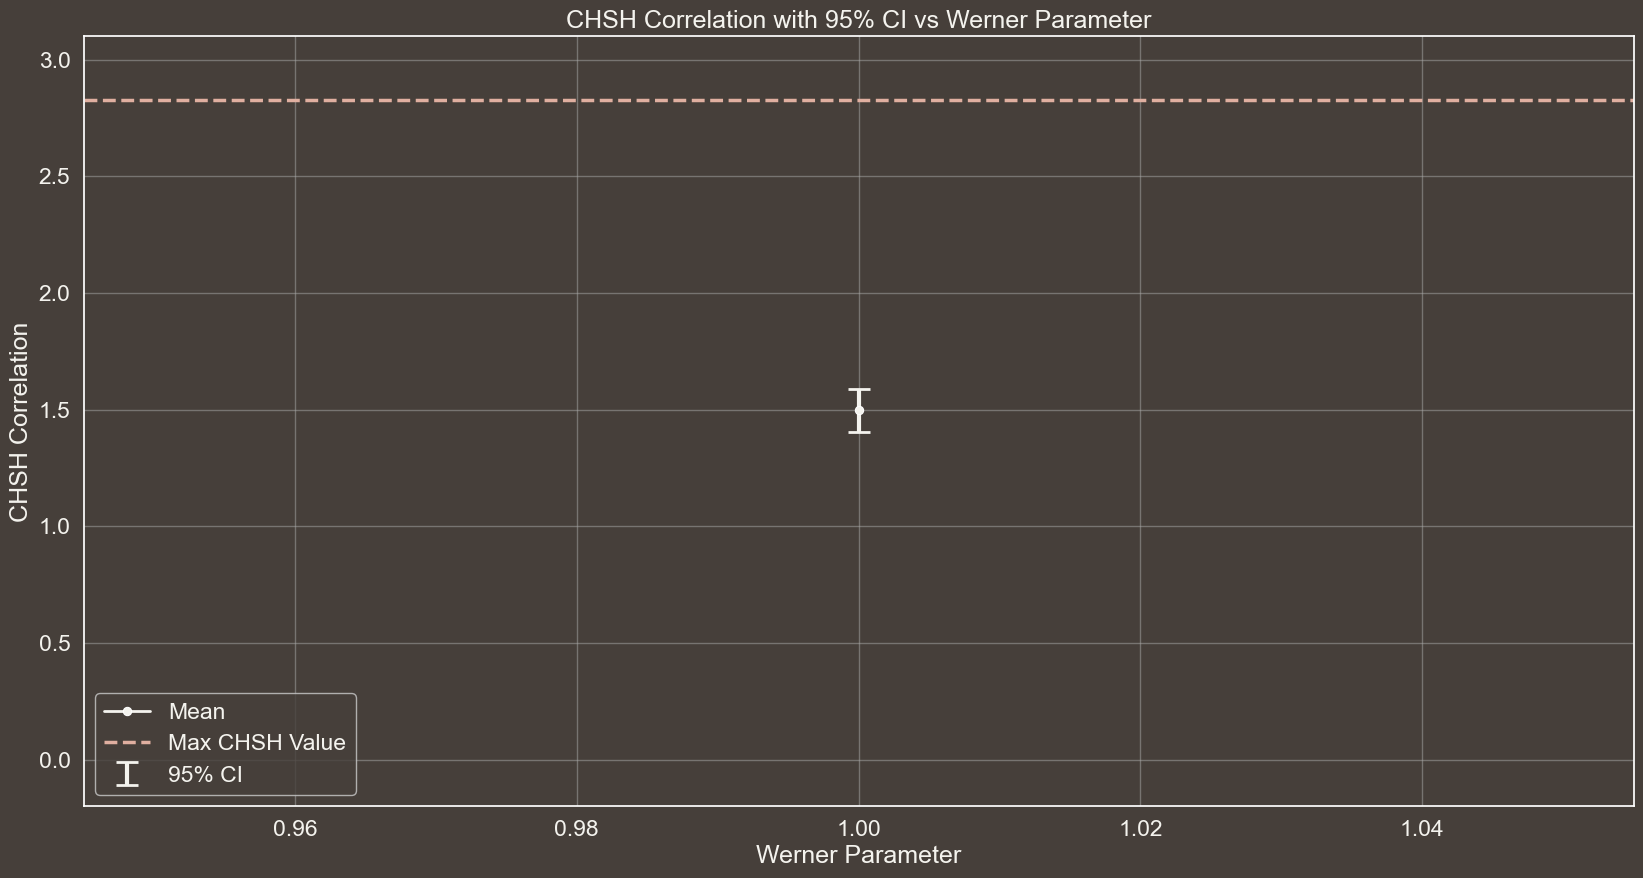

In [168]:
# S Curve 

if n > 1:
    # If the number of executions of the protocol is greater than 1

    # Setting the style of the plot
    sns.set_theme(rc={'axes.facecolor':background_color, 'figure.facecolor':background_color}, font_scale=1.5)
    plt.figure(figsize=(20, 10))
    plt.rcParams.update({'text.color': foreground_color,
                        'axes.labelcolor': foreground_color,
                        'xtick.color': foreground_color,
                        'ytick.color': foreground_color,
                        'axes.titlecolor': foreground_color})
    plt.grid(color='darkgray', alpha=0.5) 

    # Y-axis values
    y = []

    # Margin of error values for error bars
    margin_of_error = []

    # X-axis values (Werner Parameter)
    # w = sin^2(theta/2)
    w_values = [(np.sin(theta/2))**2 for theta in theta_values]

    for theta in theta_values:

        # Saving the mean value of the CHSH correlation for the current theta
        y.append(np.mean(data_collector[theta]["S"]))

        # Computing the margin of error for the 95% confidence interval of the CHSH correlation
        margin_of_error.append(1.96 * (np.std(data_collector[theta]["S"]) / math.sqrt(n)))

    if WP:
        x = w_values
        plot_title = 'CHSH Correlation with 95% CI vs Werner Parameter'
        x_label = 'Werner Parameter'
    else:
        x = theta_values
        plot_title = 'CHSH Correlation with 95% CI vs Theta'
        x_label = 'Theta [radians]'

    # Plotting the error bars using the margin of error
    plt.errorbar(x=x, y=y, fmt='o', yerr=margin_of_error, markersize=1, capsize=8, color=foreground_color, lw=3, capthick=2, label="95% CI")

    # Plotting the line
    sns.lineplot(x=x, y=y, marker='o', label="Mean", color=foreground_color, linewidth=2)

    # Plotting the theoretical maximum CHSH value (in the quantum case)
    plt.axhline(y=2*np.sqrt(2), color=special_color, linestyle='--', label="Max CHSH Value", lw=2.5)

    # Set the y-axis limits
    plt.ylim(-0.2, 3.1)

    plt.title(plot_title)
    plt.xlabel(x_label)
    plt.ylabel('CHSH Correlation')
    
    plt.legend()
    
    plt.show()

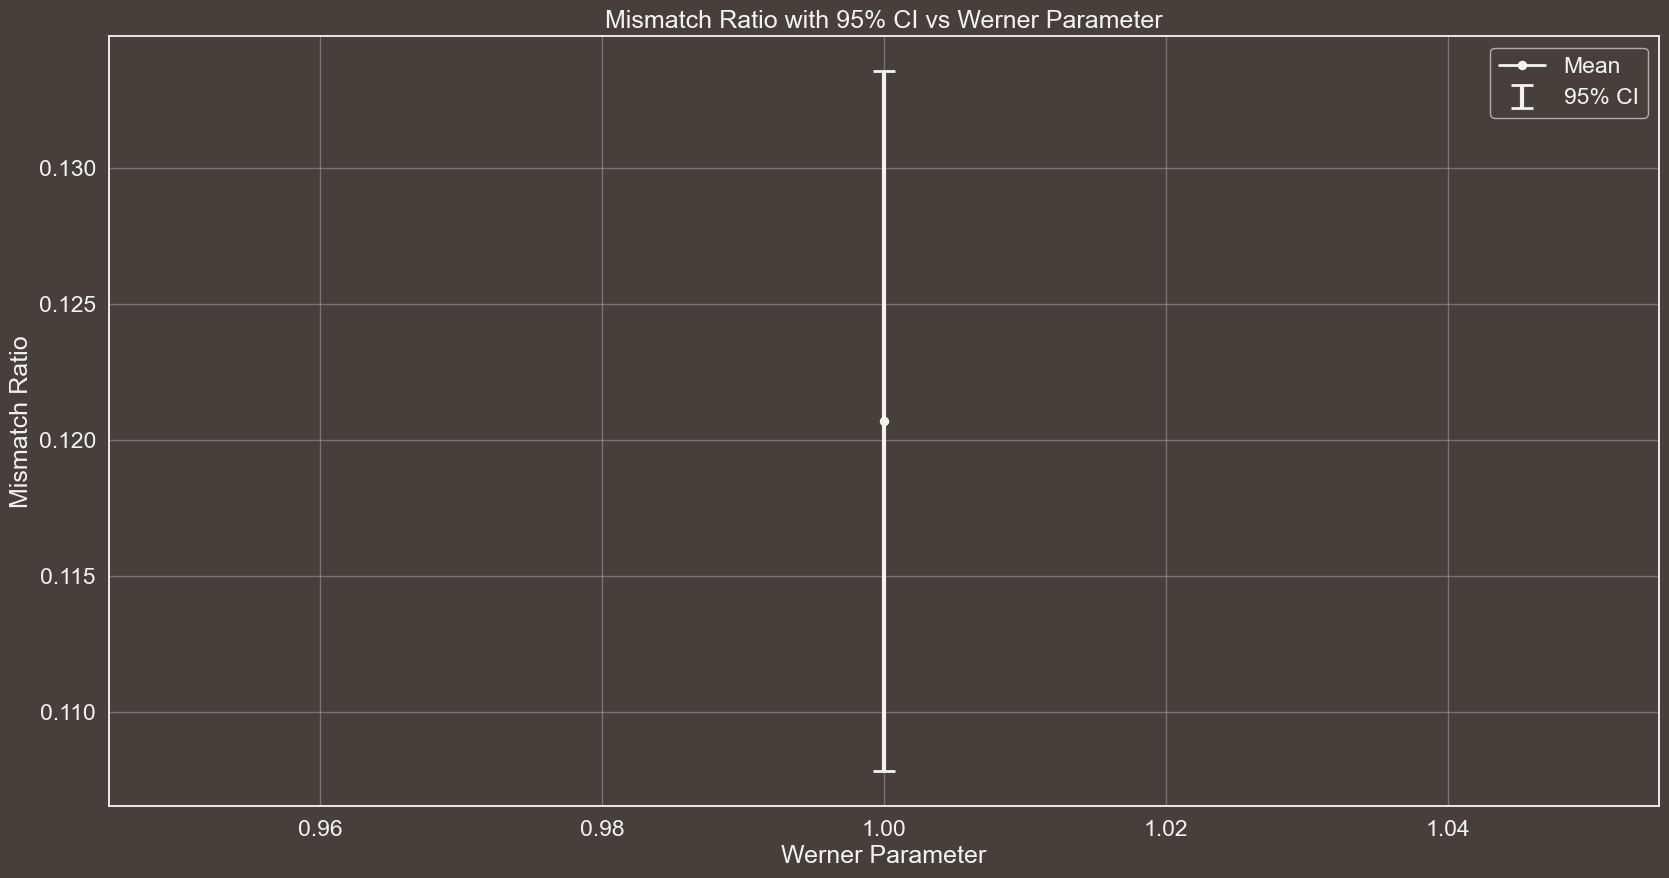

In [172]:
# Mismatch Ratio Curve 

if n > 1:
    # If the number of executions of the protocol is greater than 1

    # Setting the style of the plot
    sns.set_theme(rc={'axes.facecolor':background_color, 'figure.facecolor':background_color}, font_scale=1.5)
    plt.figure(figsize=(20, 10))
    plt.rcParams.update({'text.color': foreground_color,
                        'axes.labelcolor': foreground_color,
                        'xtick.color': foreground_color,
                        'ytick.color': foreground_color,
                        'axes.titlecolor': foreground_color})
    plt.grid(color='darkgray', alpha=0.5) 

    # Y-axis values
    y = []

    # Margin of error values for error bars
    margin_of_error = []

    # X-axis values (Werner Parameter)
    # w = sin^2(theta/2)
    w_values = [(np.sin(theta/2))**2 for theta in theta_values]


    for theta in theta_values:

        # Saving the mean value of the mismatch ratio for the current theta
        y.append(np.mean(data_collector[theta]["mismatch_ratio"]))

        # Computing the margin of error for the 95% confidence interval of the mismatch ratio
        margin_of_error.append(1.96 * (np.std(data_collector[theta]["mismatch_ratio"]) / math.sqrt(n)))

    if WP:
        x = w_values
        plot_title = 'Mismatch Ratio with 95% CI vs Werner Parameter'
        x_label = 'Werner Parameter'
    else:
        x = theta_values
        plot_title = 'Mismatch Ratio with 95% CI vs Theta'
        x_label = 'Theta [radians]'

    # Plotting the error bars using the margin of error
    plt.errorbar(x=x, y=y, fmt='o', yerr=margin_of_error, markersize=1, capsize=8, color=foreground_color, lw=3, capthick=2, label="95% CI")

    # Plotting the line
    sns.lineplot(x=x, y=y, marker='o', label="Mean", color=foreground_color, linewidth=2)

    plt.title(plot_title)
    plt.xlabel(x_label)
    plt.ylabel('Mismatch Ratio')

    plt.legend()

    plt.show()